In [1]:
# import modules

import numpy as np
import datetime

import seaborn as sns

import datetime
import gc

import math
import matplotlib as mpl
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

from sklearn.preprocessing import LabelEncoder

import gc

RANDOM_SEED = 42

%matplotlib inline

# Constants definition:
CS_Rejected = 1
CS_Entered  = 2
CS_Checked  = 4
CS_Valuated = 16

RS_Idle = 1
RS_NotSelected = 2
RS_SelectedForReview = 4
RS_Reviewed = 8
RS_Bypassed = 16

#RR:RejectionReason
RR_Accepted = 0 
RR_RbyMO    = -1

#CIS:ClaimItemStatus
CIS_Accepted = 1
CIS_Rejected = 2

/home/simona/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Step 1.1: Reading data related to the tblClaims

In [2]:
# pkl file related to the selected columns and rows from tblClaims:
df_claims_raw = pd.read_pickle('openIMIS csv/Claims2020_sel.pkl')

memStats_claims = (df_claims_raw.memory_usage()/1024/1024).sum()
shape_claims = df_claims_raw.shape

In [ ]:
df_claims_raw['ClaimAdminId'].isnull().sum()

/home/simona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/home/simona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


(array([736146., 736330., 736511., 736695., 736876., 737060., 737241.,
        737425., 737607.]), <a list of 9 Text xticklabel objects>)

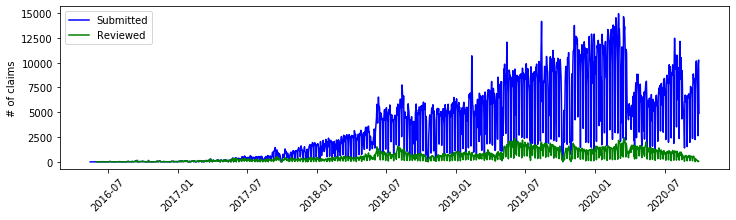

In [4]:
figs = plt.figure(figsize=(12,3))

index1 = df_claims_raw['ClaimAdminId'].notnull()
index2 = (df_claims_raw['ReviewStatus'] == RS_Reviewed)

df_sel_items = df_claims_raw.loc[index1]
df_sel_items_rew = df_claims_raw.loc[index1&index2]

#df_sel_items['DateClaimed']=pd.to_datetime(df_sel_items['DateClaimed'])
df_sel_items['DateClaimed']=df_sel_items['DateClaimed'].dt.date
df_sel_items_rew['DateClaimed']=df_sel_items_rew['DateClaimed'].dt.date

df_plot1 = df_sel_items['DateClaimed'].value_counts().sort_index()
df_plot2 = df_sel_items_rew['DateClaimed'].value_counts().sort_index()

del [[df_sel_items,df_sel_items_rew]]
df_sel_items = pd.DataFrame()
df_sel_items_rew = pd.DataFrame()
gc.collect()

plt.plot(df_plot1,'b-',label = "Submitted")
plt.plot(df_plot2,'g-',label = "Reviewed")
plt.legend(loc='upper left')
#plt.title('# of medication submissions per day')
plt.ylabel('# of claims')
plt.xticks(rotation=45)

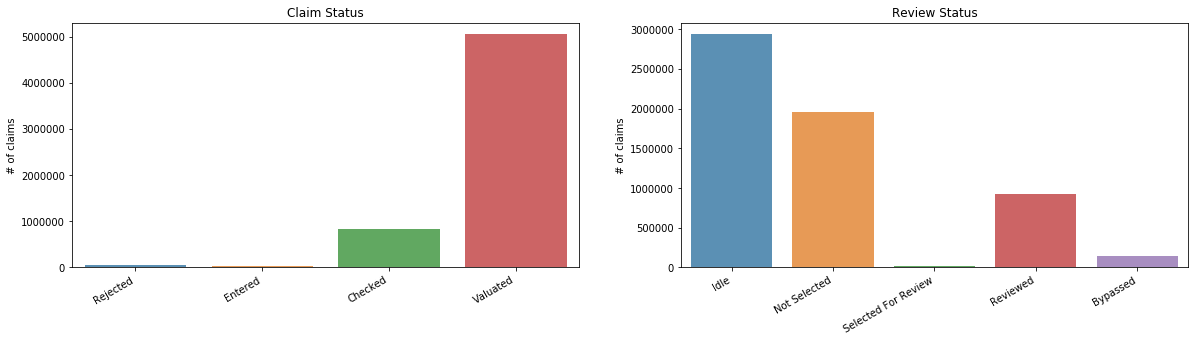

In [3]:
figs = plt.figure(figsize=(20,5))
ax1 = figs.add_subplot(121)
items_count  = df_claims_raw['ClaimStatus'].value_counts().sort_index()
sns.barplot(items_count.index, items_count.values, alpha=0.8)
plt.title("Claim Status")
plt.xticks(range(4),['Rejected','Entered', 'Checked','Valuated'])
plt.ylabel("# of claims")

ax2 = figs.add_subplot(122)
items_count  = df_claims_raw['ReviewStatus'].value_counts().sort_index()
sns.barplot(items_count.index, items_count.values, alpha=0.8)
plt.title("Review Status")
plt.xticks(range(5),['Idle', 'Not Selected','Selected For Review','Reviewed','Bypassed'])
plt.ylabel("# of claims")
plt.gcf().autofmt_xdate()

### Step 1.2: Reading the data related to tblClaimAdmins

In [ ]:
# csv file related to the tblClaimAdmins:
filename = 'openIMIS csv/claim_admins2020.csv'

# selection of columns (the entire table has 30 columns)
cols = ['ClaimAdminId', 'HFId', 'ClaimAdminUUID',\
        'ValidityFrom','ValidityTo']

# read the csv file
df_claimadmins_raw = pd.read_csv(filename,low_memory=False,usecols=cols,\
                                 parse_dates = ['ValidityFrom','ValidityTo'])
df_claimadmins_raw = df_claimadmins_raw.iloc[:-2,:]

# rename the columns in order to have similar name as the items related dataset
df_claimadmins_raw.rename(columns = {'HFID': 'ClaimAdminHFID',\
                                        'ValidityFrom': 'ClaimAdminValidityFrom',\
                                        'ValidityTo': 'ClaimAdminValidityTo'}, inplace = True)
df_claimadmins_raw['ClaimAdminId'] = df_claimadmins_raw['ClaimAdminId'].astype(float)

memStats_claimadmins = (df_claimadmins_raw.memory_usage()/1024/1024).sum()
shape_claimadmins = df_claimadmins_raw.shape

### Step 1.3: Concatenation of the tblClaims and tblClaimAdmins (based on ClaimAdminId)

In [ ]:
# Concatenate the dataframes, based on ClaimAdminID column
df_claims= pd.merge(df_claims_raw,df_claimadmins_raw,on='ClaimAdminId')

memStats_concat1 = (df_claims.memory_usage()/1024/1024).sum()
shape_concat1 = df_claims.shape

In [ ]:
print(shape_concat1)
df_claimadmins_raw['ClaimAdminId'].isnull().sum()

In [ ]:
del [[df_claims_raw,df_claimadmins_raw]]
df_claims_raw = pd.DataFrame()
df_claimadmins_raw = pd.DataFrame()
gc.collect()

### Step 2.1: Reading the file related to the tblInsurees, tblFamilies and tblLocations

In [ ]:
# read the pkl file related to the tblInsurees, tblFamilies and tblLocations
df_insuree_fmlies_locs = pd.read_pickle('openIMIS csv/Insurees_Fmlies_Loc2020_sel.pkl')

df_insuree_fmlies_locs['InsureeID']=df_insuree_fmlies_locs['InsureeID'].astype(int)

memStats_fam_loc = (df_insuree_fmlies_locs.memory_usage()/1024/1024).sum()
shape_fam_loc = df_insuree_fmlies_locs.shape

### Step 2.2: Adding the insurees, families, locations to the previous dataframe

In [ ]:
df_claim_si_concat = pd.merge(df_claims,df_insuree_fmlies_locs,on='InsureeID')

memStats_concat2 = (df_claim_si_concat.memory_usage()/1024/1024).sum()
shape_concat2 = df_claim_si_concat.shape

### Step 3.1: Reading the file related to the tbHFs and tblLocations

In [ ]:
# read the pkl file related to the tblHFs and tblLocations
df_HF_locations = pd.read_pickle('openIMIS csv/HF_Locations2020_sel.pkl')

df_HF_locations['HFID'] = df_HF_locations['HFID'].astype(float)

memStats_HF_loc = (df_HF_locations.memory_usage()/1024/1024).sum()
shape_HF_loc = df_HF_locations.shape

### Step 3.2: Adding the HFs and locations to the previous dataframe

In [ ]:
df_claim_si_concat = pd.merge(df_claim_si_concat,df_HF_locations,on='HFID')

memStats_concat3 = (df_claim_si_concat.memory_usage()/1024/1024).sum()
shape_concat3 = df_claim_si_concat.shape

### Step 4.1: Reading the files related to the tblDiagnosis

In [ ]:
# csv file related to the tblDiagnosis:
filename = 'openIMIS csv/diagnosis2020.csv'
cols = ['ICDID', 'ICDCode', 'ICDName','ValidityFrom','ValidityTo']
df_diagnosis_raw = pd.read_csv(filename,low_memory=False, usecols = cols,\
                              parse_dates =['ValidityFrom','ValidityTo'] )
df_diagnosis_raw = df_diagnosis_raw.iloc[:-2,:]

df_diagnosis_raw.rename(columns = {'ValidityFrom': 'ICDValidityFrom',\
                                     'ValidityTo': 'ICDValidityTo'}, inplace = True)


df_diagnosis_raw['ICDID'] = df_diagnosis_raw['ICDID'].astype(float)

memStats_diag = (df_diagnosis_raw.memory_usage()/1024/1024).sum()
shape_diag = df_diagnosis_raw.shape

### Step 4.2: Adding the diagnosis data to the previous dataframe

In [ ]:
df_claims_final= pd.merge(df_claim_si_concat,df_diagnosis_raw,on='ICDID')

memStats_concat4 = (df_claims_final.memory_usage()/1024/1024).sum()
shape_concat4 = df_claims_final.shape

In [ ]:
df_claims_final.to_pickle('openIMIS csv/ClaimsPlus2020_sel.pkl')
#df_claims_raw.to_csv('openIMIS csv/ClaimsPlus2020_sel.csv') 

### Summary

In [ ]:
print(f'''Summary of the concatenation process:
- tblClaims has : {shape_claims[0]} rows; {shape_claims[1]} columns;\
{round(memStats_claims,2)} MB memory consumption;
- tblClaimAdmins has : {shape_claimadmins[0]} rows; {shape_claimadmins[1]} columns;\
{round(memStats_claimadmins,2)} MB memory consumption;
- Concatenation of tblClaims and tblClaimAdmins has : {shape_concat1[0]} rows;\
{shape_concat1[1]} columns; {round(memStats_concat1,2)} MB memory consumption;
- tblInsurees/Families/Locations has : {shape_fam_loc[0]} rows; {shape_fam_loc[1]} columns;\
{round(memStats_fam_loc,2)} MB memory consumption;
- Concatenation of tblClaims/tblClaimAdmins with tblInsurees/Families/Locations has : \
{shape_concat2[0]} rows; {shape_concat2[1]} columns;\
{round(memStats_concat2,2)} MB memory consumption;
- tblHFs/Locations has : {shape_HF_loc[0]} rows; {shape_HF_loc[1]} columns;\
{round(memStats_HF_loc,2)} MB memory consumption;
- Concatenation of tblClaims/tblClaimAdmins/tblInsurees/Families/Locations with \
tblHFs/Locations has : \
{shape_concat3[0]} rows; {shape_concat3[1]} columns;\
{round(memStats_concat3,2)} MB memory consumption;
- tblDiagnosis has : {shape_diag[0]} rows; {shape_diag[1]} columns;\
{round(memStats_diag,2)} MB memory consumption;
- Concatenation of tblClaims/tblClaimAdmins/tblInsurees/Families/Locations/tblHFs/Locations \
with tblDiagnosis has : \
{shape_concat4[0]} rows; {shape_concat4[1]} columns;\
{round(memStats_concat4,2)} MB memory consumption; 
''')